In [3]:
import models
import sims
import teams
import collections
import pandas as pd
import numpy as np
from IPython.display import Image
from IPython.display import Image
from IPython.display import display
from IPython.core.display import HTML
import base64

#The Model

This model is an Alternating Renewal Reward Process. Youn can read about it more in depth here http://dukespace.lib.duke.edu/dspace/bitstream/handle/10161/6965/cdpThesis.pdf?sequence=1
But the basic idea is: based on how a team starts a possession, what is the probability that they end a possession in a certain way. I define 9 possible "states" for a transition between possessions (D-rebound, made 2 point shot, made 3 point shot, live ball turnover, dead ball turnover, free throw n out of n (1,2,or 3), or end of quarter). And looking at all of a team's possessions so far in the season, how likely is each transition. For example, a possession which starts with a steal is much more likely to end up with a made 2 point shot, so teams that get a lot of steals will get more of these 2 point shots. Independently, time of possession is modeled for each team using a Weibull distribution.


###Time distributions
Below are the fits for the Jazz and Wizards time distribution; the slowest and fastest teams in the NBA, respectively. All plots can be seen in the vis/ folder of this repo.



,

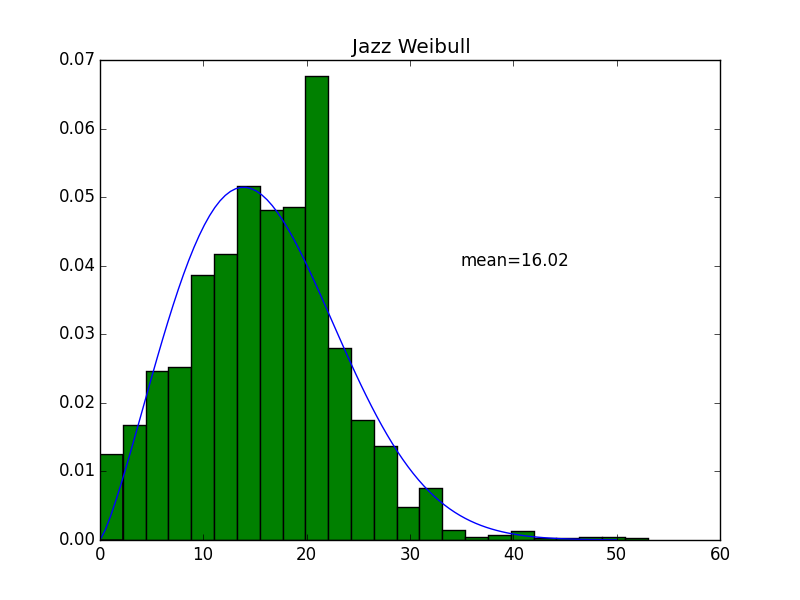
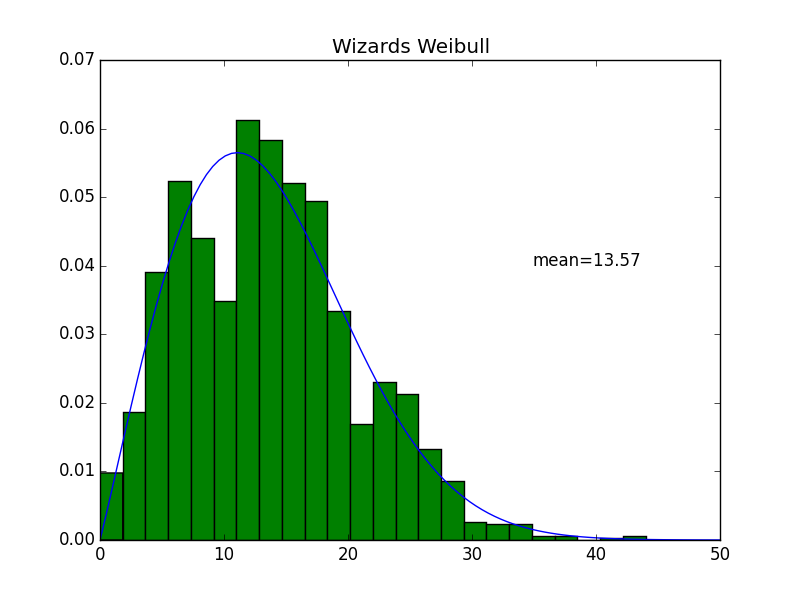

In [5]:
with open('vis/JazzWeibull.png', "rb") as image_file:
    im1 = 'data:image/png;base64,' + base64.b64encode(image_file.read())

with open("vis/WizardsWeibull.png", "rb") as image_file:
    im2 = 'data:image/png;base64,' + base64.b64encode(image_file.read())

s = """<table>
<tr>
<th><img src="%s"/></th>
<th><img src="%s"/></th>
</tr></table>"""%(im1, im2)
t=HTML(s)
display(t)

###Transition matrix
Below is a sample transition matrix. The rows are the starting events, the columns are the ending events. The entries (m,n) are the percent probabilites that a possession starts with event m and ends in event n. 

In [10]:
m = models.getTeamTrans("Warriors", "off", None)
d = pd.DataFrame(m, columns=["dummy", "dReb","Made 2", "Made 3", "turnover", "steal", "ft(1of1)", "ft(2of2)", "ft(3of3)", "end Qtr"], index=["dummy", "dReb","Made 2", "Made 3", "turnover", "steal", "ft(1of1)", "ft(2of2)", "ft(3of3)", "end Qtr"])
d

,dummy,dReb,Made 2,Made 3,turnover,steal,ft(1of1),ft(2of2),ft(3of3),end Qtr
dummy,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
dReb,0,11.385281,9.523810,5.887446,2.727273,3.679654,0.822511,2.467532,0.17316,1.125541
Made 2,0,10.606061,7.532468,3.419913,1.991342,2.251082,0.432900,2.121212,0.17316,0.519481
Made 3,0,2.207792,1.558442,0.909091,0.562771,0.865801,0.086580,0.519481,0.00000,0.086580
turnover,0,2.337662,1.558442,1.341991,0.519481,0.519481,0.000000,0.173160,0.04329,0.129870
steal,0,1.991342,3.160173,0.692641,0.649351,0.649351,0.086580,0.909091,0.04329,0.086580
ft(1of1),0,0.692641,0.389610,0.000000,0.000000,0.129870,0.000000,0.173160,0.00000,0.000000
ft(2of2),0,2.337662,2.554113,0.995671,0.303030,0.649351,0.086580,0.519481,0.04329,0.086580
ft(3of3),0,0.173160,0.129870,0.043290,0.000000,0.000000,0.000000,0.043290,0.00000,0.086580
end Qtr,0,0.952381,0.562771,0.129870,0.129870,0.216450,0.000000,0.043290,0.00000,0.000000



Game simulations are done in sims.py. Models are built in models.py, play by plays are scraped in scrape.py, and scraped play by plays are parsed for possession data in parse.py.

The main simulating function is simGame, which takes awayName/Id as the first input and homeName/Id as second input. The models are first built for each team using only their home/away games data, then 2000 games are simulated between them with the average score taken for each team. Lets simulate last year's Finals matchup for each team home and away. Also Spurs vs 76ers to see how wide these lines can get, and Warriors-Spurs to see how the best 2 teams compare. The first two elements of the output is the score.

In [3]:
print(sims.simGame("Warriors", "Cavaliers"))
print(sims.simGame("Cavaliers", "Warriors"))
print(sims.simGame("Spurs", "76ers"))
print(sims.simGame("76ers", "Spurs"))
print(sims.simGame("Spurs", "Warriors"))
print(sims.simGame("Warriors", "Spurs"))

(105.04, 101.91, 1363.3487431682972, 1541.296972704205, 98, 98)
(94.95, 101.472, 1559.0645494980249, 1345.2909536020709, 100, 100)
(96.842, 85.116, 1474.663847887161, 1430.8035839561664, 94, 93)
(80.486, 89.894, 1438.6949560203241, 1468.3285597899862, 92, 92)
(97.172, 100.0, 1565.3144693647534, 1338.1421653441985, 99, 99)
(97.51, 98.42, 1350.8816735670835, 1553.6169665495806, 97, 97)


The game is much closer when Cleveland is home, but the Warriors still win both matchups. Seems like the home/away splits are working as desired. Also, the line for Spurs at 76ers was -13.5 (Spurs) points a few days ago, while it's 11.5 points here, pretty close!

Also seems like either the Spurs at home or the 76ers play much slower away. Either way it shows in their score total which is about 12 points lower in San Antonio.


##Simulating all matchups

Lets simulate every matup possible between teams and see who comes out on top.

In [5]:
tms = teams.getAllTeams()
wins = collections.defaultdict(int)

for t1 in tms:
    tm1 = tms[t1]
    for t2 in tms:
        tm2 = tms[t2]
        if tm1['name'] != tm2['name']:
            #print(tm1['name']+ " vs "+tm2['name'])
            res = sims.simGame(tm1['name'], tm2['name'])
            if res[0] > res[1]:
                wins[tm1['loc']+' '+tm1['name']] += 1
            else:
                wins[tm2['loc']+' '+tm2['name']] += 1
            #print(res)

wins = pd.DataFrame.from_dict(wins, orient='index')
wins.columns=['w']
wins.sort('w', ascending=False)

,w
San Antonio Spurs,57
Golden State Warriors,57
Oklahoma City Thunder,51
Indiana Pacers,45
Boston Celtics,44
Cleveland Cavaliers,42
Toronto Raptors,38
Minnesota Timberwolves,37
Chicago Bulls,35
Utah Jazz,34


(                         w
Golden State Warriors   57
San Antonio Spurs       56
Oklahoma City Thunder   52
Indiana Pacers          43
Chicago Bulls           41
Cleveland Cavaliers     41
Boston Celtics          40
Charlotte Hornets       38
Minnesota Timberwolves  37
Toronto Raptors         36
Dallas Mavericks        35
New York Knicks         32
Utah Jazz               31
Miami Heat              31
Orlando Magic           31
Los Angeles Clippers    30
Atlanta Hawks           29
Phoenix Suns            27
Detroit Pistons         25
Portland Trail Blazers  23
Sacramento Kings        19
Brooklyn Nets           19
Milwaukee Bucks         18
New Orleans Pelicans    17
Washington Wizards      16
Los Angeles Lakers      12
Denver Nuggets          12
Memphis Grizzlies       11
Houston Rockets         10
Philadelphia 76ers       1,)


,

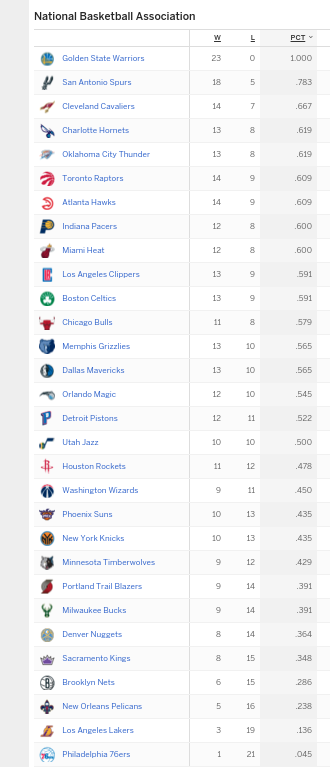
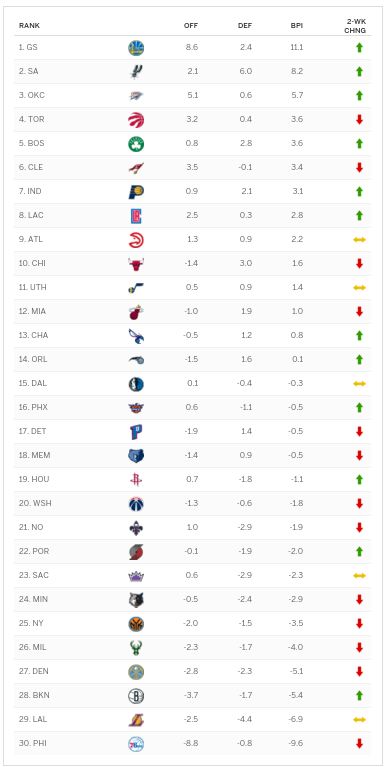

In [6]:

print(wins.sort('w', ascending=False), )


with open('nbastandings.png', "rb") as image_file:
    im1 = 'data:image/png;base64,' + base64.b64encode(image_file.read())

with open("bpi.png", "rb") as image_file:
    im2 = 'data:image/png;base64,' + base64.b64encode(image_file.read())

s = """<table>
<tr>
<th><img src="%s"/></th>
<th><img src="%s"/></th>
</tr></table>"""%(im1, im2)
t=HTML(s)
display(t)

The model seems to generally match up with the two other metrics. Although the Warriors are not t It's not completely in line with the Eastern Conference Standings at the top in terms of order of teams, but there is very little separating those teams in the standings. The Rockets are especially bad in the model, and the Wizards and Hawks also under perform. The Timberwolves do very well in the model. Will see how this changes throughout the season.



##Shortcomings of the model
The time of possession is independent to the amount of time on the clock. This can lead to inaccuracy in end of game situations, the result is often determined. The model also doesn't consider time since previous game. Building these into the model is future work, as is using the shots database to factor in teams' shot selection.
